In [37]:
import pandas as pd
from uta import solve_lp_problem_gms, plot_utility_functions, create_full_ranking_df, check_consistency, obtain_relations

In [38]:
df = pd.read_csv('Nuclear waste management.csv', index_col=0)

In [39]:
preferential_information = [(5, 1), (11, 24), (14, 27)]
indifference_information = [(3, 7), (22, 23)]

In [40]:
problem, u_vars, criteria = solve_lp_problem_gms(df, preferential_information, indifference_information, verbose=False)

Status: Optimal


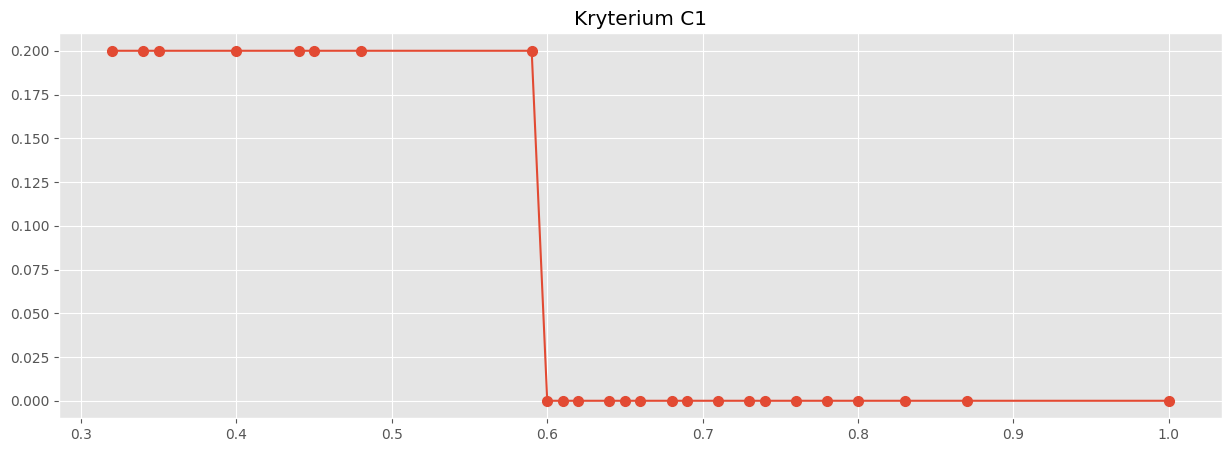

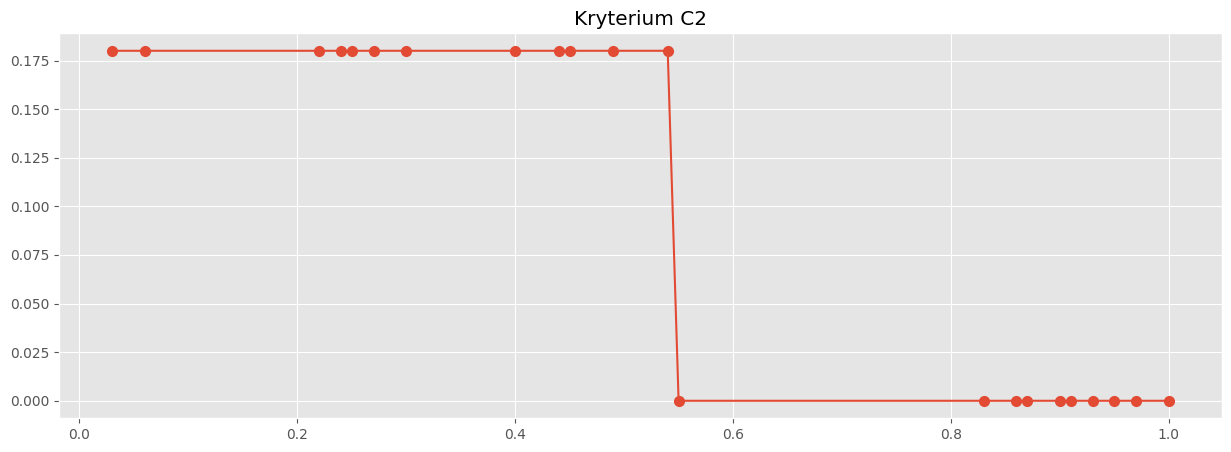

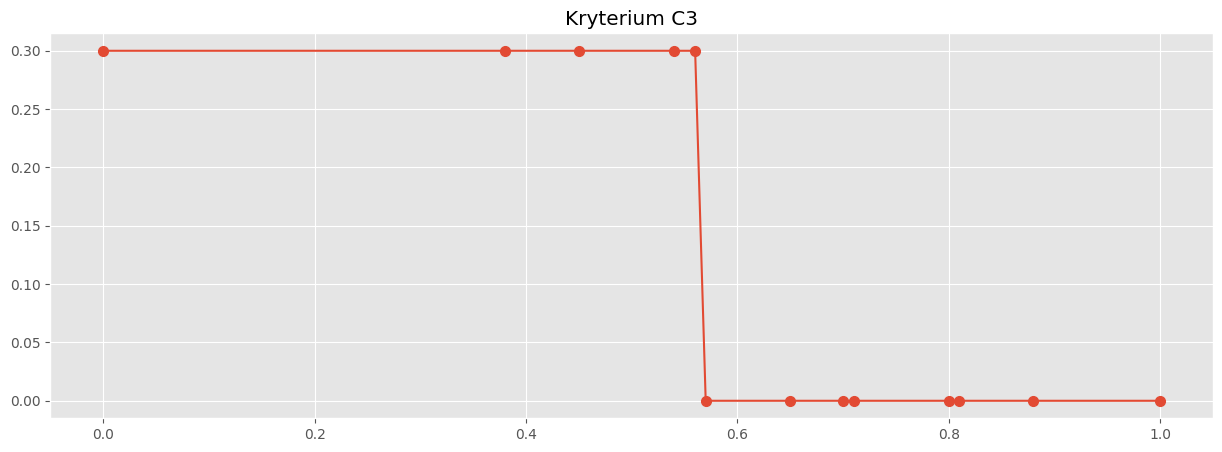

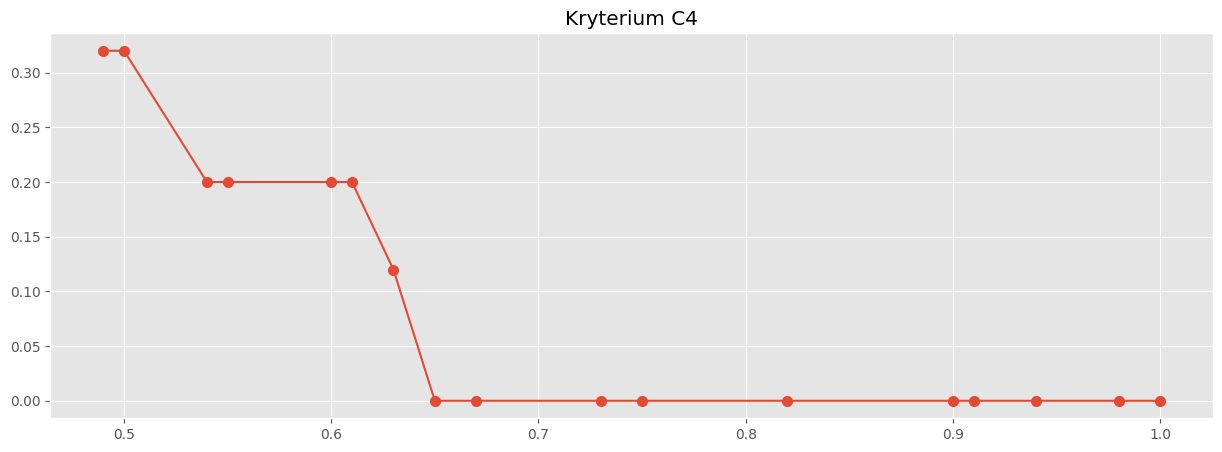

In [41]:
plot_utility_functions(problem, u_vars, criteria)

Brzydki ostatni wykres - inne wartosci f.uzytecznosci czastk. dla wariantow majacych taka sama wartosc na danym kryterium - dziwne, ale na slajdach w ten sposob jest problem formułowany (nierówność nieostra):

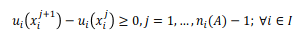

In [42]:
rank = create_full_ranking_df(df, problem, criteria)

In [43]:
check_consistency(rank, preferential_information, indifference_information)

True

In [44]:
rank.sort_values(by='U', ascending=False)

,C1,C2,C3,C4,u1,u2,u3,u4,U
11,0.61,0.54,0.38,0.49,0.0,0.18,0.3,0.32,0.8
5,0.62,0.40,0.56,0.50,0.0,0.18,0.3,0.32,0.8
8,0.64,0.44,0.54,0.54,0.0,0.18,0.3,0.2,0.68
14,0.69,0.49,0.56,0.61,0.0,0.18,0.3,0.2,0.68
2,0.66,0.55,0.45,0.49,0.0,0.0,0.3,0.32,0.62
4,0.48,0.87,0.00,0.75,0.2,0.0,0.3,0.0,0.5
12,0.74,0.25,0.80,0.49,0.0,0.18,0.0,0.32,0.5
19,0.35,0.91,0.00,0.98,0.2,0.0,0.3,0.0,0.5
16,0.44,0.95,0.00,0.90,0.2,0.0,0.3,0.0,0.5
6,0.78,0.27,0.71,0.50,0.0,0.18,0.0,0.32,0.5


In [45]:
necessarily_preferred, possibly_preffered = obtain_relations(rank)

In [46]:
all_alternatives = [v for s in preferential_information + indifference_information for v in s]
data = necessarily_preferred.copy()
data = {key: [val for val in values if val in all_alternatives] for key, values in data.items() if key in all_alternatives}

In [47]:
edges = []
for node, successors in data.items():
    for successor in successors:
        edges.append((node, successor))

In [48]:
data

{1: [],
 3: [24, 27],
 5: [1, 3, 11, 14, 24, 27],
 7: [1, 22],
 11: [1, 3, 5, 14, 24, 27],
 14: [1, 24, 27],
 22: [1, 7],
 23: [24, 27],
 24: [27],
 27: []}

In [49]:
to_delete = [(11,1)] # ...
ec = edges.copy()

for el in to_delete:
    index = ec.index(el)
    ec = ec[:index] + ec[index+1:]

In [50]:
# G = nx.DiGraph(ec)
# pos = nx.nx_agraph.graphviz_layout(G)
# plt.figure(figsize=(10, 10))  # Adjust figure size as needed
# nx.draw(G, pos, node_color='skyblue', edge_color='gray', with_labels=True, node_size=500)
# plt.title("Preference graph")
# plt.show()

In [51]:
# pomysl: pokazmy tylko pozdbior tego grafu dla naszych wariantow ktore byly wyzglednione w informacji referencyjnej
# moge usunac te nadmiarowe krawedzie recznie nie mam pomyslu jak to inaczej zrobic
# wydaje sie to czytelniejsze I guess

In [52]:
from uta import most_representative_function
problem2, u_vars2, criteria2 = most_representative_function(
        df,
        preferential_information,
        indifference_information,
        necessarily_preferred,
        possibly_preffered,
        verbose=False)

rank2 = create_full_ranking_df(df, problem2, criteria2)

Status: Optimal


In [53]:
print(check_consistency(rank2, preferential_information, indifference_information))
rank2.sort_values(by='U', ascending=False)

True


,C1,C2,C3,C4,u1,u2,u3,u4,U
11,0.61,0.54,0.38,0.49,0.0,0.18,0.3,0.32,0.8
5,0.62,0.40,0.56,0.50,0.0,0.18,0.3,0.32,0.8
8,0.64,0.44,0.54,0.54,0.0,0.18,0.3,0.2,0.68
14,0.69,0.49,0.56,0.61,0.0,0.18,0.3,0.2,0.68
2,0.66,0.55,0.45,0.49,0.0,0.0,0.3,0.32,0.62
4,0.48,0.87,0.00,0.75,0.2,0.0,0.3,0.0,0.5
12,0.74,0.25,0.80,0.49,0.0,0.18,0.0,0.32,0.5
19,0.35,0.91,0.00,0.98,0.2,0.0,0.3,0.0,0.5
16,0.44,0.95,0.00,0.90,0.2,0.0,0.3,0.0,0.5
6,0.78,0.27,0.71,0.50,0.0,0.18,0.0,0.32,0.5


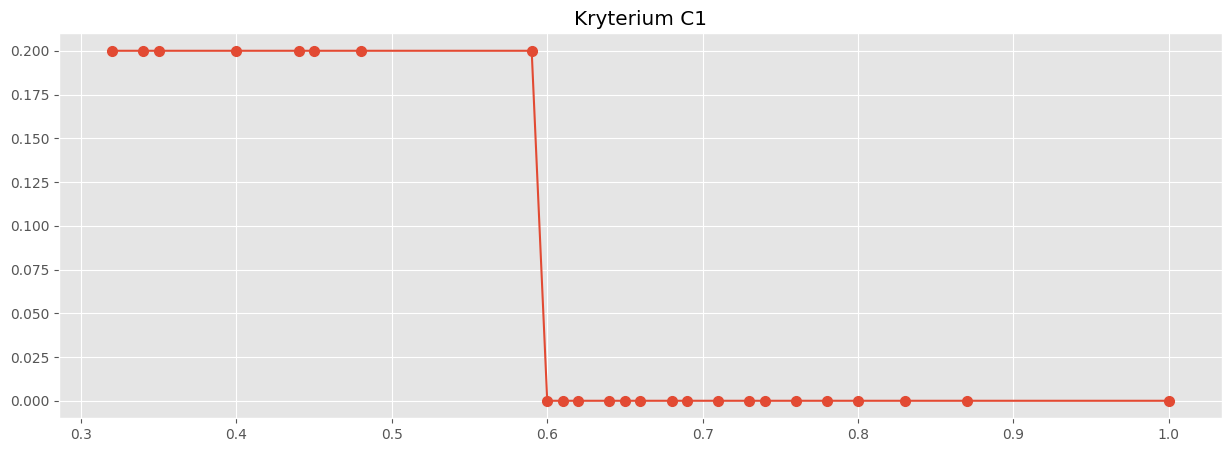

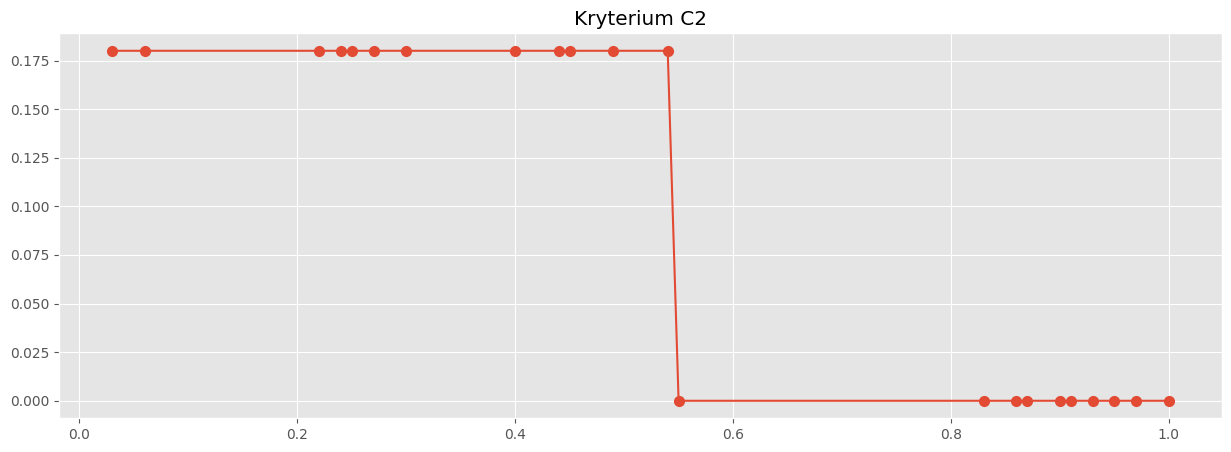

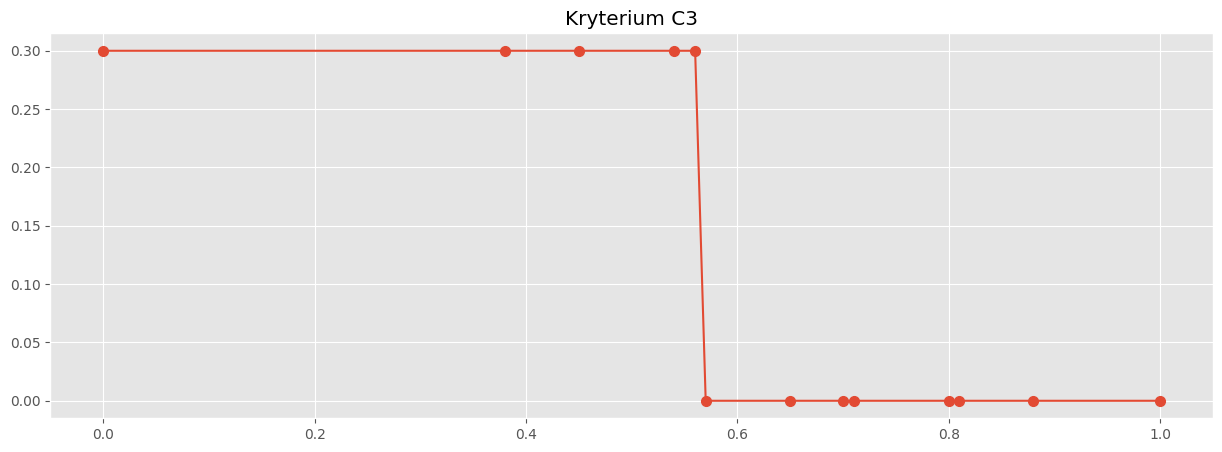

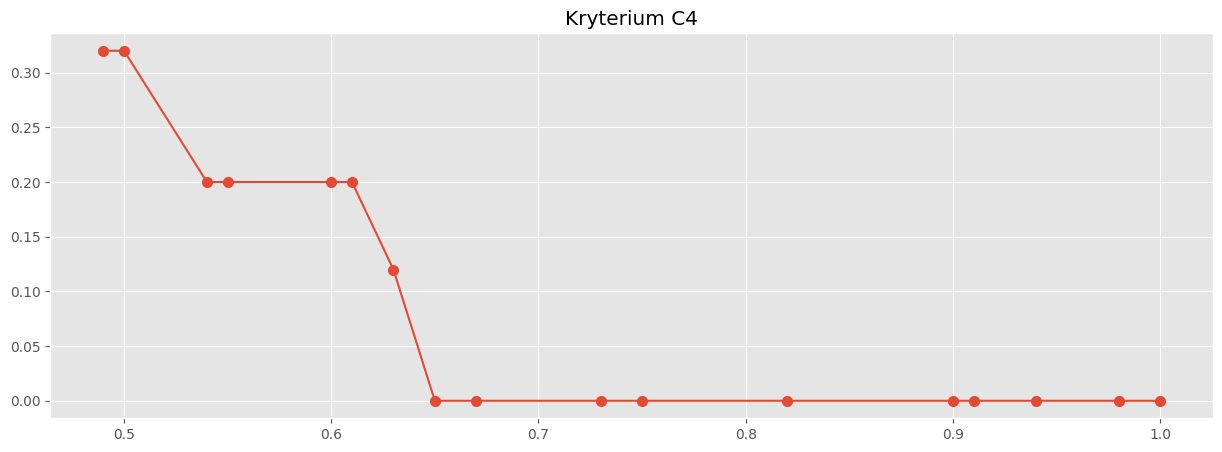

In [54]:
plot_utility_functions(problem, u_vars, criteria)